# Loan default probability


The predicted variable is “Charge-Off ”. A charge-off is a debt that a creditor has given up trying to collect on after you’ve missed payments for several months. The predicted variable takes value 1 in case of charge-off and 0 otherwise.

### Loading the python packages

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD

#Libraries for Saving the Model
from pickle import dump
from pickle import load

import warnings
warnings.filterwarnings('ignore')

## Loading the Data

In [2]:
# load dataset
dataset= pd.read_csv('LoansData_sample.csv.gz', compression='gzip', encoding='utf-8')
dataset.info()
dataset.head()
dataset.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 151 entries, Unnamed: 0 to settlement_term
dtypes: float64(115), int64(2), object(34)
memory usage: 115.2+ MB


(100000, 151)

## Data Preparation and Feature Selection

### Preparing the predicted variable

In [3]:
dataset['loan_status'].value_counts(dropna=False)

Fully Paid            69982
Charged Off           16156
Current               12726
Late (31-120 days)      730
In Grace Period         264
Late (16-30 days)       139
Default                   3
Name: loan_status, dtype: int64

We only keep the loans with status "Fully Paid" or "Charged Off."

In [4]:
dataset = dataset.loc[dataset['loan_status'].isin(['Fully Paid', 'Charged Off'])]
dataset['loan_status'].value_counts(dropna=False)
dataset['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid     0.812441
Charged Off    0.187559
Name: loan_status, dtype: float64

About 81.24% of the remaining loans have been fully paid and 18.75% have charged off.

In [5]:
#charged off = 1
#Fully paid = 0
dataset['charged_off'] = (dataset['loan_status'] == 'Charged Off').apply(np.uint8)
dataset.drop('loan_status', axis=1, inplace=True)
dataset['charged_off']

0        0
1        1
2        0
4        1
5        0
        ..
99994    0
99995    0
99996    0
99998    1
99999    0
Name: charged_off, Length: 86138, dtype: int64

### Feature Selection-Limit the Feature Space
We eliminate features in following steps using three different approaches:

- Eliminate feature that have more than 30% missing values.

- Eliminate features that are unintuitive based on subjective judgement.

- Eliminate features with low correlation with the predicted variable

#### Features elimination by significant missing values

Calculating the percentage of missing data for each feature:



In [6]:
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
dataset.drop(labels=drop_list, axis=1, inplace=True)
print('number of features after removal: ',dataset.shape[1])

number of features after removal:  93


#### Features elimination based on the intutiveness

We check the description in the data dictionary and maintain features that are intuitive based on subjective judgment.


In [7]:
print(sorted(dataset.columns))

['Unnamed: 0', 'acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'charged_off', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_

In [8]:
keep_list = ['charged_off','funded_amnt','addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code','last_pymnt_amnt','num_actv_rev_tl', 'mo_sin_rcnt_rev_tl_op','mo_sin_old_rev_tl_op',"bc_util","bc_open_to_buy","avg_cur_bal","acc_open_past_24mths" ]
drop_list = [col for col in dataset.columns if col not in keep_list]
dataset.drop(labels=drop_list, axis=1, inplace=True)
print('number of features after removal: ',dataset.shape[1])

number of features after removal:  39


### Features elimination based on the correlation

In [9]:
correlation = dataset.corr()
correlation_chargeOff = abs(correlation['charged_off'])
correlation_chargeOff.sort_values(ascending=False)

charged_off              1.000000
last_pymnt_amnt          0.319081
int_rate                 0.282825
dti                      0.123108
fico_range_low           0.121892
fico_range_high          0.121891
acc_open_past_24mths     0.105989
bc_open_to_buy           0.080077
bc_util                  0.077744
avg_cur_bal              0.071977
num_actv_rev_tl          0.071185
revol_util               0.066188
funded_amnt              0.060818
loan_amnt                0.060818
mort_acc                 0.057858
annual_inc               0.050349
mo_sin_old_rev_tl_op     0.049426
mo_sin_rcnt_rev_tl_op    0.048839
open_acc                 0.039430
installment              0.032847
revol_bal                0.021714
pub_rec                  0.016023
pub_rec_bankruptcies     0.015815
total_acc                0.005804
id                       0.002221
Name: charged_off, dtype: float64

In [10]:
drop_list_corr = sorted(list(correlation_chargeOff[correlation_chargeOff < 0.03].index))
print(drop_list_corr)
dataset.drop(labels=drop_list_corr, axis=1, inplace=True)
print('number of features after removal: ',dataset.shape[1])


['id', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'total_acc']
number of features after removal:  34


##  Feature Engineering and Exploratory Analysis

### Analysing the categorical features

In [11]:
#Descriptive Statistics
dataset.describe()

,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,open_acc,revol_util,last_pymnt_amnt,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,charged_off
count,86138.000000,86138.000000,86138.000000,86138.000000,8.613800e+04,86138.000000,86138.000000,86138.000000,86138.000000,86094.000000,86138.000000,86138.000000,86138.000000,85142.000000,85089.000000,86138.000000,86138.000000,86138.000000,86138.000000,86138.000000
mean,14106.526446,14106.526446,13.002360,430.737187,7.384311e+04,18.532747,692.462966,696.463024,11.746453,54.582777,4757.453184,4.594732,13066.638371,8942.506507,63.808959,183.524333,12.796896,1.748880,5.762358,0.187559
std,8391.139221,8391.139221,4.397419,251.653139,5.929352e+04,8.538247,29.731549,29.731848,5.433122,23.515901,6466.767327,3.070996,16232.739293,14100.186250,27.051347,93.266430,16.224586,2.091488,3.224598,0.390362
min,1000.000000,1000.000000,6.000000,30.420000,4.000000e+03,0.000000,660.000000,664.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,7800.000000,7800.000000,9.490000,248.480000,4.500000e+04,12.070000,670.000000,674.000000,8.000000,37.200000,358.522500,2.000000,3010.000000,1087.000000,44.100000,118.000000,3.000000,0.000000,3.000000,0.000000
50%,12000.000000,12000.000000,12.990000,370.480000,6.247372e+04,17.950000,685.000000,689.000000,11.000000,54.900000,1241.230000,4.000000,6994.500000,3823.000000,67.700000,167.000000,8.000000,1.000000,5.000000,0.000000
75%,20000.000000,20000.000000,15.610000,568.005000,9.000000e+04,24.500000,705.000000,709.000000,14.000000,72.500000,7303.205000,6.000000,17905.000000,10588.000000,87.500000,232.000000,15.000000,3.000000,7.000000,0.000000
max,35000.000000,35000.000000,26.060000,1408.130000,7.500000e+06,39.990000,845.000000,850.000000,84.000000,180.300000,36234.440000,53.000000,447433.000000,249625.000000,255.200000,718.000000,372.000000,34.000000,38.000000,1.000000


In [12]:
print(dataset[['emp_title','title','zip_code']])
dataset[['emp_title','title','zip_code']].describe()


                                      emp_title                    title  \
0                                    MANAGEMENT       Debt consolidation   
1                Truck Driver Delivery Personel  Credit card refinancing   
2               Programming Analysis Supervisor  Credit card refinancing   
4                          Technical Specialist       Debt consolidation   
5                              Admin Specialist       Debt consolidation   
...                                         ...                      ...   
99994  Senior Clinical Business Solutions Analy       Debt consolidation   
99995                         Software Engineer       Debt consolidation   
99996            Assistant Professor of English       Debt consolidation   
99998                  Records Examiner Analyst       Debt consolidation   
99999             Occupational Theapy Assistant       Debt consolidation   

      zip_code  
0        235xx  
1        937xx  
2        658xx  
4        850xx  
5 

,emp_title,title,zip_code
count,81416,86138,86138
unique,32987,20,846
top,Teacher,Debt consolidation,750xx
freq,1576,52990,954


In [13]:
#These columns are not useful for modeling.
dataset.drop(['emp_title','title','zip_code'], axis=1, inplace=True)

##### Feature - Term

In [14]:
#"The number of payments on the loan. Values are in months and can be either 36 or 60.". 
#The 60 Months loans are more likelely to charge off
#Convert term to integers
dataset['term'] = dataset['term'].apply(lambda s: np.int8(s.split()[0]))
dataset.groupby('term')['charged_off'].value_counts(normalize=True).loc[:,1]

term
36    0.141526
60    0.354356
Name: charged_off, dtype: float64

Loans with five-year periods are more than twice as likely to charge-off as loans with three-year periods.


##### Feature - Employement Length

In [15]:
dataset['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)
dataset['emp_length'].replace('< 1 year', '0 years', inplace=True)
dataset['emp_length']

0        10 years
1         8 years
2         6 years
4         0 years
5        10 years
           ...   
99994    10 years
99995     2 years
99996     3 years
99998    10 years
99999     3 years
Name: emp_length, Length: 86138, dtype: object

In [16]:
def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
dataset['emp_length'] = dataset['emp_length'].apply(emp_length_to_int)
dataset['emp_length']

0        10.0
1         8.0
2         6.0
4         0.0
5        10.0
         ... 
99994    10.0
99995     2.0
99996     3.0
99998    10.0
99999     3.0
Name: emp_length, Length: 86138, dtype: float64

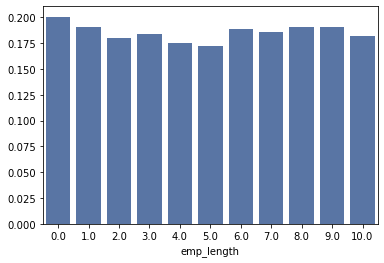

In [17]:
charge_off_rates = dataset.groupby('emp_length')['charged_off'].value_counts(normalize = True).loc[:,1]
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1)
plt.show()

Loan status does not appear to vary much with employment length on average, hence it is dropped

In [18]:
dataset.drop(['emp_length'], axis=1, inplace=True)

##### Feature : Subgrade

In [19]:
dataset['sub_grade']

0        C1
1        A3
2        D1
4        C3
5        C3
         ..
99994    B2
99995    B1
99996    C1
99998    F4
99999    B2
Name: sub_grade, Length: 86138, dtype: object

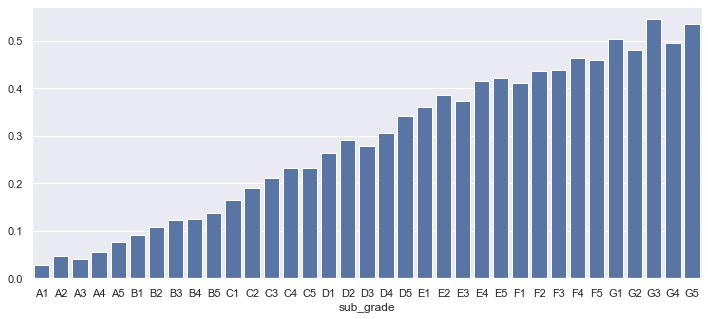

In [20]:
charge_off_rates = dataset.groupby('sub_grade')['charged_off'].value_counts(normalize=True).loc[:,1]
sns.set(rc={'figure.figsize':(12,5)})
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1)
plt.show()

There's a clear trend of higher probability of charge-off as the subgrade worsens, and so it is considered to be a key feature.

In [21]:
dataset['earliest_cr_line']

0        Aug-1994
1        Sep-1989
2        Aug-2003
4        Aug-2002
5        Nov-1992
           ...   
99994    Nov-1984
99995    Aug-1990
99996    May-2001
99998    Nov-2000
99999    Jul-1999
Name: earliest_cr_line, Length: 86138, dtype: object

In [22]:
dataset['earliest_cr_line'] = dataset['earliest_cr_line'].apply(lambda s: int(s[-4:]))
dataset['earliest_cr_line']


0        1994
1        1989
2        2003
4        2002
5        1992
         ... 
99994    1984
99995    1990
99996    2001
99998    2000
99999    1999
Name: earliest_cr_line, Length: 86138, dtype: int64

### Analysing the continuous features
#### Feature : Annual Income



In [23]:
print(dataset['annual_inc'].describe())
dataset['annual_inc'].head(10)

count    8.613800e+04
mean     7.384311e+04
std      5.929352e+04
min      4.000000e+03
25%      4.500000e+04
50%      6.247372e+04
75%      9.000000e+04
max      7.500000e+06
Name: annual_inc, dtype: float64


0      78000.0
1      58000.0
2      63800.0
4      50000.0
5      69000.0
6      89000.0
7     109777.0
8      72000.0
9      26000.0
10     90000.0
Name: annual_inc, dtype: float64

Annual income ranges from 0 to 9,550,000, with a median of $65,000. Because of the large range of incomes, we should take a log transform of the annual income variable.

In [24]:
dataset['log_annual_inc'] = dataset['annual_inc'].apply(lambda x: np.log10(x+1))
dataset.drop('annual_inc', axis=1, inplace=True)
dataset['log_annual_inc'].head(10)

0     4.892100
1     4.763435
2     4.804827
4     4.698979
5     4.838855
6     4.949395
7     5.040515
8     4.857339
9     4.414990
10    4.954247
Name: log_annual_inc, dtype: float64

#### FICO Scores


In [25]:
print(dataset[['fico_range_low','fico_range_high']].head())
dataset[['fico_range_low','fico_range_high']].corr()

   fico_range_low  fico_range_high
0           750.0            754.0
1           710.0            714.0
2           685.0            689.0
4           685.0            689.0
5           680.0            684.0


,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


Given that the correlation between fico low and high is 1 it is preferred to keep only one feature which is average of FICO Scores

In [26]:
dataset['fico_score'] = 0.5*dataset['fico_range_low'] + 0.5*dataset['fico_range_high']
dataset.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)

## Encoding Categorical Data


In order to use a feature in the classification models, we need to convert the categorical data (i.e., text features) to its numeric representation. This process is called encoding. There can be different ways of encoding. However, for this case study we will use a label encoder, which encodes labels with a value between 0 and n, where n is the number of distinct labels. The LabelEncoder function from sklearn is used in the following step, and all the categorical columns are encoded at once:


In [27]:
from sklearn.preprocessing import LabelEncoder

In [28]:
# Categorical boolean mask
categorical_feature_mask = dataset.dtypes==object
print(categorical_feature_mask)
# filter categorical columns using mask and turn it into a list
categorical_cols = dataset.columns[categorical_feature_mask].tolist()
categorical_cols

loan_amnt                False
funded_amnt              False
term                     False
int_rate                 False
installment              False
grade                     True
sub_grade                 True
home_ownership            True
verification_status       True
purpose                   True
addr_state                True
dti                      False
earliest_cr_line         False
open_acc                 False
revol_util               False
initial_list_status       True
last_pymnt_amnt          False
application_type          True
acc_open_past_24mths     False
avg_cur_bal              False
bc_open_to_buy           False
bc_util                  False
mo_sin_old_rev_tl_op     False
mo_sin_rcnt_rev_tl_op    False
mort_acc                 False
num_actv_rev_tl          False
charged_off              False
log_annual_inc           False
fico_score               False
dtype: bool


['grade',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_state',
 'initial_list_status',
 'application_type']

In [29]:
le = LabelEncoder()
# apply le on categorical feature columns
dataset[categorical_cols] = dataset[categorical_cols].apply(lambda col: le.fit_transform(col))
dataset[categorical_cols].head(10)

,grade,sub_grade,home_ownership,verification_status,purpose,addr_state,initial_list_status,application_type
0,2,10,3,1,2,40,1,0
1,0,2,1,0,1,4,1,0
2,3,15,3,1,1,21,1,0
4,2,12,3,1,2,3,0,0
5,2,12,3,1,2,26,0,0
6,1,9,1,1,3,20,0,0
7,1,8,2,2,2,40,1,0
8,2,13,3,1,1,42,0,0
9,1,8,3,0,2,18,0,0
10,1,9,3,2,2,19,0,0


In [30]:
print(dataset.shape)
dataset.head(5)

(86138, 29)


,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,verification_status,purpose,...,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,charged_off,log_annual_inc,fico_score
0,15000.0,15000.0,60,12.39,336.64,2,10,3,1,2,...,29828.0,9525.0,4.7,244.0,1.0,0.0,4.0,0,4.892100,752.0
1,10400.0,10400.0,36,6.99,321.08,0,2,1,0,1,...,9536.0,7599.0,41.5,290.0,1.0,1.0,9.0,1,4.763435,712.0
2,21425.0,21425.0,60,15.59,516.36,3,15,3,1,1,...,4232.0,324.0,97.8,136.0,7.0,0.0,4.0,0,4.804827,687.0
4,7650.0,7650.0,36,13.66,260.20,2,12,3,1,2,...,5857.0,332.0,93.2,148.0,8.0,0.0,4.0,1,4.698979,687.0
5,9600.0,9600.0,36,13.66,326.53,2,12,3,1,2,...,3214.0,6494.0,69.2,265.0,23.0,0.0,7.0,0,4.838855,682.0


### 4.3. Sampling Data

Given that the loan data is skewed, it is sampled to have an equal number of charge-off and no charge-off observations. Sampling leads to a more balanced dataset and avoids overfitting:

In [31]:
dataset['charged_off'].value_counts()

0    69982
1    16156
Name: charged_off, dtype: int64

In [32]:
loanstatus_0 = dataset[dataset["charged_off"]==0]
loanstatus_1 = dataset[dataset["charged_off"]==1]
subset_of_loanstatus_0 = loanstatus_0.sample(n=5500)
subset_of_loanstatus_1 = loanstatus_1.sample(n=5500)
dataset = pd.concat([subset_of_loanstatus_1, subset_of_loanstatus_0])
dataset = dataset.sample(frac=1).reset_index(drop=True)
print("Current shape of dataset :",dataset.shape)
dataset.head()

Current shape of dataset : (11000, 29)


,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,verification_status,purpose,...,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,charged_off,log_annual_inc,fico_score
0,8000.0,8000.0,36,14.49,275.33,2,13,1,1,2,...,2446.0,2772.0,60.4,141.0,8.0,1.0,7.0,1,4.579795,667.0
1,35000.0,35000.0,36,14.99,1213.12,2,14,1,1,2,...,48146.0,11882.0,76.0,187.0,6.0,2.0,12.0,0,5.628390,692.0
2,12000.0,12000.0,36,8.39,378.20,0,4,1,0,2,...,16506.0,2571.0,80.2,183.0,4.0,4.0,5.0,0,4.770712,667.0
3,15000.0,15000.0,36,13.66,510.20,2,12,3,1,2,...,6922.0,54.0,98.7,82.0,37.0,0.0,2.0,1,4.623260,707.0
4,18000.0,18000.0,60,22.99,507.33,5,25,3,2,2,...,2098.0,5733.0,45.9,36.0,2.0,0.0,10.0,1,4.778158,662.0


In [33]:
#Filling the NAs with the mean of the column.
dataset.fillna(dataset.mean(),inplace = True)

## Evaluate Algorithms and Models

### Train Test Split

In [34]:
# split out validation dataset for the end
Y= dataset["charged_off"]
X = dataset.loc[:, dataset.columns != 'charged_off']
validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [35]:
dataset['charged_off'].value_counts()

1    5500
0    5500
Name: charged_off, dtype: int64

### Test Options and Evaluation Metrics

In this step, the test options and evaluation metrics are selected. The roc_auc evaluation metric is selected for this classification. The details of this metric were provided in Chapter 4. This metric represents a model’s ability to discriminate between positive and negative classes. An roc_auc of 1.0 represents a model that made all predictions perfectly, and a value of 0.5 represents a model that is as good as random.

The model cannot afford to have a high amount of false negatives as that leads to a negative impact on the investors and the credibility of the company.


In [36]:
# test options for classification
num_folds = 10
seed = 7
#scoring = 'accuracy'
#scoring ='precision'
#scoring ='recall'
scoring = 'roc_auc'

### Compare Models and Algorithms
#### Classification Models

In [37]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

#### K-folds cross validation

In [38]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.900582 (0.010846)
LDA: 0.901475 (0.008522)
KNN: 0.805001 (0.018246)
CART: 0.801485 (0.020415)
NB: 0.900416 (0.007390)
NN: 0.882578 (0.012128)
AB: 0.927824 (0.009463)
GBM: 0.938418 (0.007599)
RF: 0.930843 (0.008064)
ET: 0.917582 (0.009122)


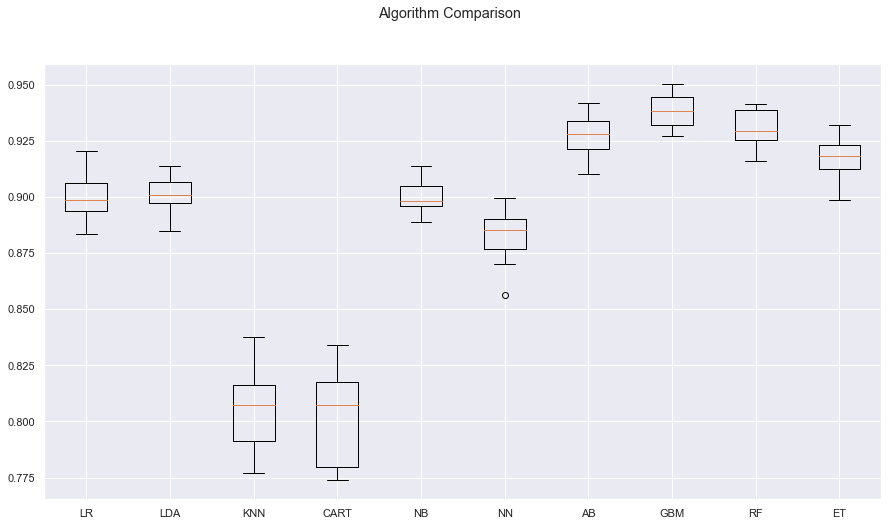

In [39]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

## Model Tuning and Grid Search
Given that the Gradient Boosting is the best model, Grid Search is performed on GBM in this step.


In [40]:
# Grid Search: GradientBoosting Tuning
'''
n_estimators : int (default=100)
    The number of boosting stages to perform. 
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; the best value depends on the interaction of the input variables.

''' 
n_estimators = [20,180]
max_depth= [3,5]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)
model = GradientBoostingClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.937238 using {'max_depth': 3, 'n_estimators': 180}
#4 0.927996 (0.006938) with: {'max_depth': 3, 'n_estimators': 20}
#1 0.937238 (0.007689) with: {'max_depth': 3, 'n_estimators': 180}
#3 0.932544 (0.007129) with: {'max_depth': 5, 'n_estimators': 20}
#2 0.936368 (0.008464) with: {'max_depth': 5, 'n_estimators': 180}


## Finalise the Model
Looking at the details above GBM might be worthy of further study, but for now SVM shows a lot of promise as a low complexity and stable model for this problem.

Finalize Model with best parameters found during tuning step.

In [41]:
# prepare model
model = GradientBoostingClassifier(max_depth= 5, n_estimators= 180)
model.fit(X_train, Y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=180,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(max_depth=5, n_estimators=180)

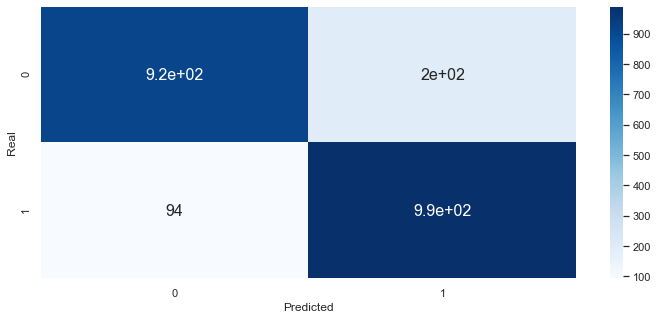

              precision    recall  f1-score   support

           0       0.91      0.82      0.86      1117
           1       0.83      0.91      0.87      1083

    accuracy                           0.87      2200
   macro avg       0.87      0.87      0.87      2200
weighted avg       0.87      0.87      0.87      2200



In [42]:
# estimate accuracy on validation set

dataset.describe()
predictions = model.predict(X_validation)
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Real'
df_cm.columns.name = 'Predicted'

sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes
plt.show()
print(classification_report(Y_validation, predictions))

### Variable Intuition/Feature Importance

Looking at the details above GBM might be worthy of further study. Let us look into the Feature Importance of the GBM model



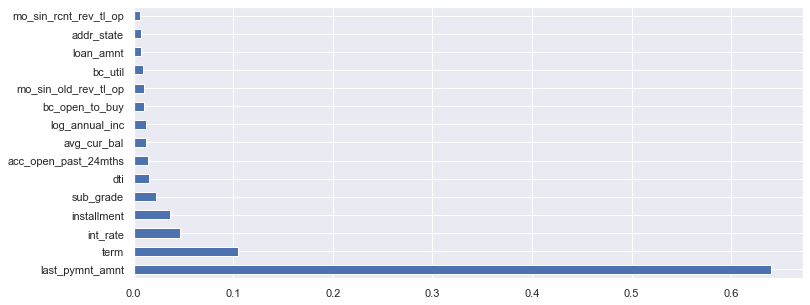

In [43]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

The results of the model importance are intuitive. The last payment amount seems to be the most important feature, followed by loan term and sub-grade.
 

### Conclusion:


Performing data processing and establishing an understanding of variable importance is key in the model development process. A focus on these steps led to the implementation of a simple classification-based model that produced robust results for default prediction.

